In [18]:
from sklearn.preprocessing import label_binarize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sn
from gensim.models import Word2Vec
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


In [10]:
# function to load the pickle data
def loadPickleData(filename):
    pickle_off = open(filename,"rb")
    final = pickle.load(pickle_off)
    return final


In [24]:
final = loadPickleData('final.pickle')
X = final['CleanedText'][22000:25000]
y = final['Score'][22000:25000]

In [26]:
encoded_column_vector = label_binarize(y, classes=['negative','positive']) 
y = np.ravel(encoded_column_vector)

In [30]:
final.columns


Index(['Score', 'CleanedText'], dtype='object')

In [31]:
cnt = Counter()
for word in y:
    cnt[word]+=1
cnt

Counter({1: 2664, 0: 336})

In [40]:
def plot_tsne(X,y):
 

    model = TSNE(n_components=2, random_state=0)
    tsne_data = model.fit_transform(X)


    # creating a new data frame which help us in ploting the result data
    tsne_data = np.vstack((tsne_data.T, y)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne
    sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.show()

###  BOW

In [44]:
count_vect = CountVectorizer()
bow_feature_train = count_vect.fit_transform(X)

/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


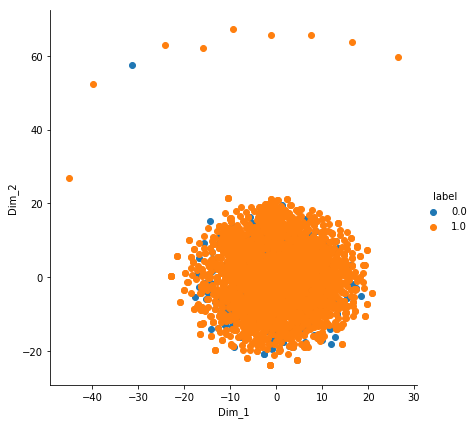

In [45]:
plot_tsne(bow_feature_train.toarray(),y)

### Tfidf

In [48]:
tfidf_vect = TfidfVectorizer()
tfidf_feature_train = tfidf_vect.fit_transform(X)

/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


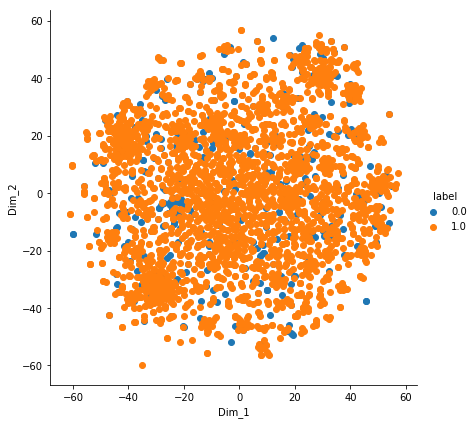

In [49]:
plot_tsne(tfidf_feature_train.toarray(),y)

### AvgW2V

In [50]:
def getListOfSentences(values):
    list_of_sent=[]
    for sent in values:
        list_of_sent.append(sent.split())
    return list_of_sent

In [51]:
list_of_sent = getListOfSentences(X.values)
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [52]:
# average Word2Vec
# compute average word2vec for each review.

def findAvgWord2Vec(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors
    


In [53]:
sent_vectors = findAvgWord2Vec(list_of_sent)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 3000/3000 [00:01<00:00, 1682.86it/s]

3000
50


/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


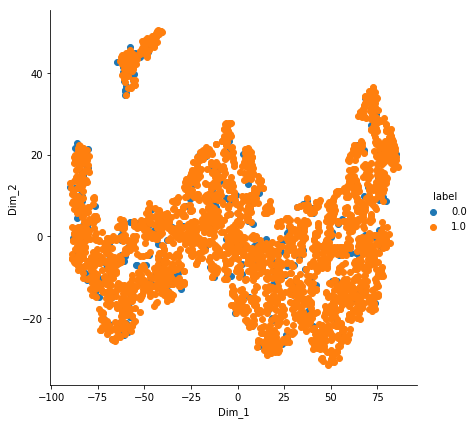

In [54]:
plot_tsne(sent_vectors,y)

### Tfidf W2V

In [55]:
def findTfidfW2V(values):
    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(values)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    
    list_of_sent=[]
    for sent in values:
        list_of_sent.append(sent.split())
        
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [56]:
tfidf_sent_vectors = findTfidfW2V(X.values)
print(len(tfidf_sent_vectors))

100%|██████████| 3000/3000 [00:02<00:00, 1322.99it/s]

3000


/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


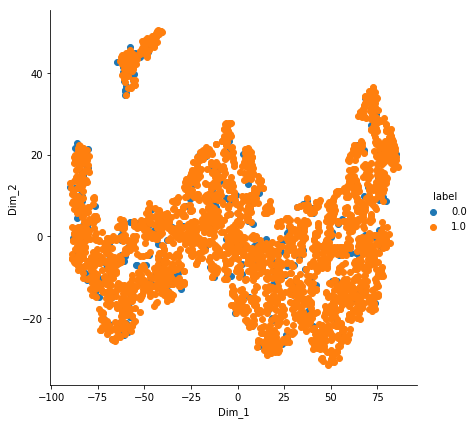

In [57]:
plot_tsne(sent_vectors,y)